## 回归预测x与y的关系

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123456)

print("")

### 1. 先构造点x、y的数据

In [2]:
x = [-6.0, -4.0, -1.2, -1.6, 1.0, 1.5, 2.3, 1.9, 3.3, 4.2, 5.0, 7.7, 8.2]
x = torch.tensor(x)

In [3]:
x.shape

torch.Size([13])

In [4]:
# 随机获取13个1-3的随机数
# torch.randint(1, 3, (13,))

In [5]:
# 随机处理一下y，让其随机调整一下
# y = 3.456 * x - 16.0
# y = y - torch.randn(x.size(0)) * torch.randint(1, 3, (x.size(0),))
# y

In [6]:
y = torch.tensor([
    -36.8778, -26.4276, -19.5442, -20.2848, -10.5902, -13.0207, -10.1414, -9.3716,
    -4.7571,  -1.8561, 1.2260,  12.6646,  12.8662
])

In [7]:
x.shape, y.shape

(torch.Size([13]), torch.Size([13]))

**到这里我们就得到x和y的数据了。**   
先对其进行可视化一下。



In [8]:
points = []
for i in range(x.size(0)):
    item = (x[i].item(), y[i].item())
    points.append(item)
# points

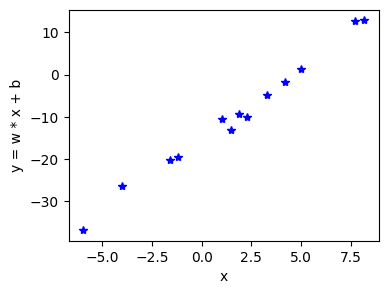

In [9]:
fig = plt.figure(figsize=(4,3), dpi=100)  # figsize: 设置图形的尺寸，单位为英寸，dpi:设置每英寸点数，设置图像的分辨率，默认是100
plt.xlabel("x")
plt.ylabel("y = w * x + b")
# plt.scatter(x.numpy(), y.numpy(), label="points", color="blue", zorder=1)
plt.plot(x.numpy(), y.numpy(), '*', color="blue")
plt.show()

### 2. 初始化一个w和b

模型：
```bash
y = w * x + b
```

In [10]:
# 模型
def model(source, w, b):
    return w * source + b

In [11]:
# 损失函数
def loss_function(predict, real_value):
    squared_diffs = (predict - real_value)**2
    return squared_diffs.mean()

In [12]:
# 先实例化一个w和b
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [13]:
# 我们给模型设置一个初始的w和b：计算预测的值
predict = model(x, w, b)
predict

tensor([-6.0000, -4.0000, -1.2000, -1.6000,  1.0000,  1.5000,  2.3000,  1.9000,
         3.3000,  4.2000,  5.0000,  7.7000,  8.2000])

In [14]:
# 计算损失的值
loss_function(predict, y)

tensor(225.4881)

**接下来我们就想怎么估算`w`和`b`了。** 使损失达到最小。

### 3. 沿着梯度下降

In [15]:
# 我们设置一个梯度：逐步的调整w/b
delta = 0.05

loss_rate_change_w = (loss_function(model(x, w + delta, b), y) - loss_function(model(x, w - delta, b), y)) / (2.0 * delta)

In [16]:
loss_rate_change_w

tensor(-38.3202)

In [17]:
loss_rate_change_b = (loss_function(model(x, w, b + delta), y) - loss_function(model(x, w, b - delta), y)) / (2.0 * delta)

In [18]:
loss_rate_change_b

tensor(22.8331)

In [19]:
w, b

(tensor(1.), tensor(0.))

In [20]:
# 根据一个学习率来调整w和b
learning_rate = 0.01
w = w - learning_rate * loss_rate_change_w
b = b - learning_rate * loss_rate_change_b

In [21]:
w, b

(tensor(1.3832), tensor(-0.2283))

In [22]:
# 再一次计算损失
predict = model(x, w, b)
loss_function(predict, y)

tensor(208.1460)

**看比上一次的`tensor(225.4881)`小了。**

### 4. 基于上面的汇总分析

#### 4.1 计算导数

```
dloss_function / dw = (dloss_function / dpredict) * (dpredict / dw)
```

```python
# 损失函数
def loss_function(predict, real_value):
    squared_diffs = (predict - real_value)**2
    return squared_diffs.mean()
```

In [23]:
# 得到dloss_function
def dloss_function(predict, real_value):
    # 把 `predict - real_value`看成个整体,u**2的导数是：2 * u
    dsquared_diffs = 2 * (predict - real_value) / predict.size(0)
    # 返回其均值的导数
    return dsquared_diffs

#### 4.2 将导数应用到模型中

```python
# 模型
def model(source, w, b):
    return w * source + b
```

In [24]:
# 得到w偏导数: 把b和source看成一个常数，w是个变量
def dmodel_dw(source, w, b):
    return source

In [25]:
# 得到b偏导数: 把w和source看成一个常数，b是个变量
def dmodel_db(source, w, b):
    # w * source是个常数，那么其导数是0， b的一次方导数是1
    return 1.0

#### 4.3 定义阶梯函数

把上面的`dloss_function`、`dmodel_dw`、`dmodel_db`全部放在一起，返回关于`w`和`b`的损失梯度的函数：

In [26]:
def grad_function(source, real_value, predict, w, b):
    dloss_dpredict = dloss_function(predict, real_value)
    dloss_dw = dloss_dpredict * dmodel_dw(source, w, b)
    dloss_db = dloss_dpredict * dmodel_db(source, w, b)
    target = torch.stack([dloss_dw.sum(), dloss_db.sum()])
    return target

### 5. 训练循环

In [27]:
def training_loop(epochs, learning_rate, params, source, real_value, print_step=10):
    for epoch in range(epochs):
        w, b = params

        # 正向传播
        predict = model(source, w, b)
        # 计算损失
        loss = loss_function(predict, real_value)
        # 反向传播
        grad = grad_function(source, real_value, predict, w, b)
        # 参数
        params = params - learning_rate * grad
        # 输出日志信息
        if  epoch == 0 or (epoch + 1) % print_step == 0:
            print("第{}次训练, Loss is {:.2f}, params: {}".format(epoch + 1, float(loss), params))
    # 返回参数
    return params

In [28]:
# 调用训练循环
params = torch.tensor([1.0, 0.0])
training_loop(epochs=200, learning_rate=0.01, params=params, source=x, real_value=y)

第1次训练, Loss is 225.49, params: tensor([ 1.3832, -0.2283])
第10次训练, Loss is 154.45, params: tensor([ 2.1524, -2.3442])
第20次训练, Loss is 110.75, params: tensor([ 2.3524, -4.3962])
第30次训练, Loss is 79.59, params: tensor([ 2.5154, -6.1294])
第40次训练, Loss is 57.38, params: tensor([ 2.6529, -7.5928])
第50次训练, Loss is 41.54, params: tensor([ 2.7690, -8.8284])
第60次训练, Loss is 30.25, params: tensor([ 2.8670, -9.8718])
第70次训练, Loss is 22.20, params: tensor([  2.9498, -10.7527])
第80次训练, Loss is 16.46, params: tensor([  3.0197, -11.4965])
第90次训练, Loss is 12.37, params: tensor([  3.0787, -12.1245])
第100次训练, Loss is 9.45, params: tensor([  3.1286, -12.6548])
第110次训练, Loss is 7.37, params: tensor([  3.1707, -13.1026])
第120次训练, Loss is 5.89, params: tensor([  3.2062, -13.4806])
第130次训练, Loss is 4.83, params: tensor([  3.2362, -13.7999])
第140次训练, Loss is 4.08, params: tensor([  3.2615, -14.0694])
第150次训练, Loss is 3.54, params: tensor([  3.2829, -14.2970])
第160次训练, Loss is 3.16, params: tensor([  3.3010, -14

tensor([  3.3491, -15.0017])

In [29]:
# 把学习比率调低一点试下
params = torch.tensor([1.0, 0.0])
params = training_loop(epochs=30000, learning_rate=0.0001, params=params, source=x, real_value=y, print_step=2000)
params

第1次训练, Loss is 225.49, params: tensor([ 1.0038, -0.0023])
第2000次训练, Loss is 107.76, params: tensor([ 2.3491, -4.3648])
第4000次训练, Loss is 56.16, params: tensor([ 2.6487, -7.5479])
第6000次训练, Loss is 29.79, params: tensor([ 2.8625, -9.8237])
第8000次训练, Loss is 16.31, params: tensor([  3.0154, -11.4508])
第10000次训练, Loss is 9.41, params: tensor([  3.1247, -12.6140])
第12000次训练, Loss is 5.89, params: tensor([  3.2029, -13.4457])
第14000次训练, Loss is 4.09, params: tensor([  3.2588, -14.0403])
第16000次训练, Loss is 3.17, params: tensor([  3.2987, -14.4654])
第18000次训练, Loss is 2.70, params: tensor([  3.3273, -14.7693])
第20000次训练, Loss is 2.46, params: tensor([  3.3477, -14.9866])
第22000次训练, Loss is 2.34, params: tensor([  3.3623, -15.1419])
第24000次训练, Loss is 2.27, params: tensor([  3.3727, -15.2530])
第26000次训练, Loss is 2.24, params: tensor([  3.3802, -15.3324])
第28000次训练, Loss is 2.23, params: tensor([  3.3855, -15.3891])
第30000次训练, Loss is 2.22, params: tensor([  3.3893, -15.4297])


tensor([  3.3893, -15.4297])

In [30]:
# 把线画出来
x_line = np.linspace(-10,10,500)

In [31]:
y_line = params[0].item() * x_line + params[1].item()

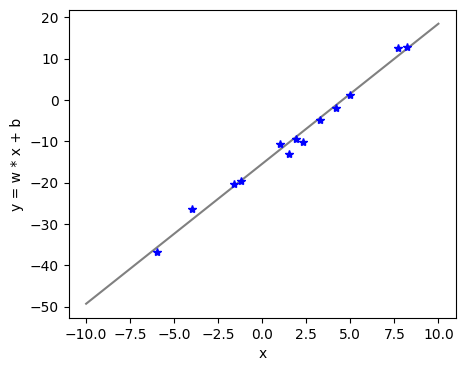

In [32]:
fig = plt.figure(figsize=(5,4), dpi=100)
plt.xlabel("x")
plt.ylabel("y = w * x + b")
plt.plot(x_line, y_line, label="y = w*x + b", color="gray")
plt.plot(x.numpy(), y.numpy(), '*', color="blue")
plt.show()